In [14]:
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from configs import limiting_schemes_2d, problem_configs, solver_config
from finite_volume.advection import AdvectionSolver


limiting_schemes = limiting_schemes_2d


viridis = mpl.colormaps["viridis"]


def color_p(p):
    return viridis(p / 7)

In [15]:
data = []
for n, p, lckey in product(
    [32, 64, 128, 256, 512], range(8), ["aPrioriFixedDt", "aPrioriT"]
):
    solver = AdvectionSolver(
        n=(n,),
        order=p + 1,
        cupy=256,
        adjust_stepsize=6,
        **problem_configs["sinus2d"],
        **limiting_schemes[lckey],
        **solver_config,
    )
    solver.rkorder(rk6=True)

    # measure error and record
    err = solver.snapshots[-1]["u"] - solver.snapshots[0]["u"]
    l1 = np.mean(np.abs(err))
    l2 = np.sqrt(np.mean(np.square(err)))
    integrator_names = {
        "euler": "Euler",
        "ssprk2": "SSPRK2",
        "ssprk3": "SSPRK3",
        "rk4": "RK4",
        "rk6": "RK6",
    }
    data.append(
        dict(
            n=n,
            p=p,
            integrator=integrator_names[solver.integrator_name],
            C=solver.courant,
            scheme=lckey,
            l1_err=l1,
            l2_err=l2,
        )
    )

df = pd.DataFrame(data)

Reassigned C=0.44898481932374923 for order 7
Reassigned C=0.44898481932374923 for order 7
Reassigned C=0.25198420997897464 for order 8
Reassigned C=0.25198420997897464 for order 8
Reassigned C=0.4 for order 7
Reassigned C=0.4 for order 7
Reassigned C=0.2 for order 8
Reassigned C=0.2 for order 8
Reassigned C=0.35635948725613575 for order 7
Reassigned C=0.35635948725613575 for order 7
Reassigned C=0.15874010519681997 for order 8
Reassigned C=0.15874010519681997 for order 8
Reassigned C=0.31748021039363994 for order 7
Reassigned C=0.31748021039363994 for order 7
Reassigned C=0.12599210498948732 for order 8
Reassigned C=0.12599210498948732 for order 8
Reassigned C=0.28284271247461906 for order 7
Reassigned C=0.28284271247461906 for order 7
Reassigned C=0.10000000000000003 for order 8
Reassigned C=0.10000000000000003 for order 8


In [29]:
df.head()
np.abs(
    df[df.scheme == "aPrioriFixedDt"].reset_index().l1_err
    - df[df.scheme == "aPrioriT"].reset_index().l1_err
) / df[df.scheme == "aPrioriFixedDt"].reset_index().l1_err

0     0.000000
1     0.000000
2     0.000315
3     0.168890
4     0.000367
5     0.170978
6     0.000316
7     0.153068
8     0.000000
9     0.000000
10    0.000080
11    0.280848
12    0.000092
13    0.214653
14    0.000079
15    0.241484
16    0.000000
17    0.000000
18    0.000020
19    0.331922
20    0.000023
21    0.228445
22    0.000019
23    0.026462
24    0.000000
25    0.000000
26    0.000005
27    0.347362
28    0.000006
29    0.251944
30    0.000760
31    0.000166
32    0.000000
33    0.000000
34    0.000001
35    0.351422
36    0.000002
37    0.055706
38    0.001496
39    0.000071
Name: l1_err, dtype: float64

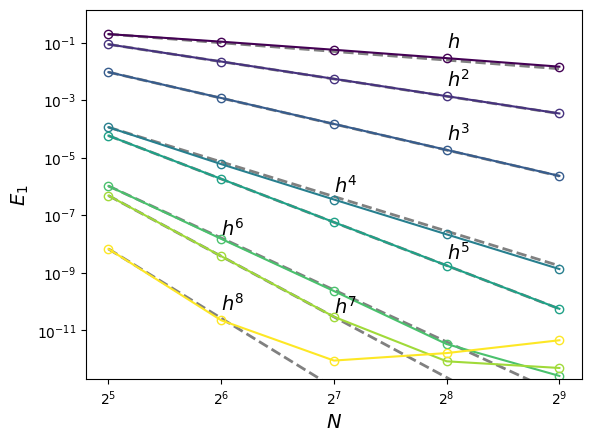

In [5]:
# plotting
fig, ax = plt.subplots()
ax.set_xscale("log", base=2)
ax.set_yscale("log")

plotted_scheme = "aPrioriFixedDt"
make_legend = False

df_plot = df[df.scheme == plotted_scheme]
p_grouped = df_plot.groupby("p")

# plot theoretical curves
for p_name, p_group in p_grouped:
    y0 = p_group.l1_err.max()
    n0 = p_group.n.min()
    nmax = p_group.n.max()
    n_ratio = n0 / nmax
    ypred = y0 * (n_ratio ** (p_name + 1))
    ax.plot([n0, nmax], [y0, ypred], linestyle="--", linewidth=2, color="grey")

# plot actual curves
for p_name, p_group in p_grouped:
    ax.plot(
        p_group.n,
        p_group.l1_err,
        "-",
        marker="o",
        color=color_p(p_name),
        mfc="none",
        label=f"$p={p_name}$",
    )

# labels
fontsize = 14
ax.text(2**8, 7e-2, "$h$", size=fontsize)
ax.text(2**8, 3e-3, "$h^2$", size=fontsize)
ax.text(2**8, 4e-5, "$h^3$", size=fontsize)
ax.text(2**7, 6e-7, "$h^4$", size=fontsize)
ax.text(2**8, 3e-9, "$h^5$", size=fontsize)
ax.text(2**6, 2e-8, "$h^6$", size=fontsize)
ax.text(2**7, 4e-11, "$h^7$", size=fontsize)
ax.text(2**6, 5e-11, "$h^8$", size=fontsize)

# cosmetics
if make_legend:
    leg = ax.legend(loc="center", bbox_to_anchor=(1.15, 0.5), fontsize=fontsize)
    for line, p in zip(leg.get_lines(), range(8)):
        line.set_linestyle("none")
        line.set_marker("s")
        line.set_markersize(23)
        line.set_markerfacecolor(color_p(p))
ax.set_ylim(2e-13, None)
ax.set_xlabel("$N$", fontsize=fontsize)
ax.set_ylabel("$E_1$", fontsize=fontsize)
fig.savefig(
    f"images/images_sinus_convergence_{plotted_scheme}.png",
    dpi=300,
    bbox_inches="tight",
)

In [6]:
# add columns for computing actual error rate
df = df.sort_values(by=["scheme", "p", "n"])

l1_err = df.l1_err.to_numpy()
rates = np.full_like(df.l1_err, np.nan)
rates[1:] = np.log2(l1_err[:-1] / l1_err[1:])
df["l1_err_rate"] = rates

l2_err = df.l2_err.to_numpy()
rates = np.full_like(df.l1_err, np.nan)
rates[1:] = np.log2(l2_err[:-1] / l2_err[1:])
df["l2_err_rate"] = rates

df.loc[df.n == 32, ("l1_err_rate", "l2_err_rate")] = None

df.head()

,n,p,integrator,C,scheme,l1_err,l2_err,l1_err_rate,l2_err_rate
0,32,0,Euler,0.8,aPrioriFixedDt,0.196954,0.218881,NaN,NaN
16,64,0,Euler,0.8,aPrioriFixedDt,0.107560,0.119479,0.872716,0.873389
32,128,0,Euler,0.8,aPrioriFixedDt,0.056263,0.062494,0.934874,0.934976
48,256,0,Euler,0.8,aPrioriFixedDt,0.028782,0.031969,0.967040,0.967058
64,512,0,Euler,0.8,aPrioriFixedDt,0.014557,0.016169,0.983418,0.983421


In [7]:
# reformat dataframe for table generation
df_l1 = df
df_l1 = df_l1.drop(columns=["l2_err", "l2_err_rate"])
df_l1 = df_l1.rename(columns={"l1_err": "err", "l1_err_rate": "err_rate"})
df_l1["err_type"] = "L1"
df_l2 = df
df_l2 = df_l2.drop(columns=["l1_err", "l1_err_rate"])
df_l2 = df_l2.rename(columns={"l2_err": "err", "l2_err_rate": "err_rate"})
df_l2["err_type"] = "L2"
df = pd.concat([df_l1, df_l2])

df_abs = df
df_abs = df_abs.drop(columns="err_rate")
df_abs["val_type"] = "abs"
df_rate = df
df_rate = df_rate.drop(columns="err")
df_rate = df_rate.rename(columns={"err_rate": "err"})
df_rate["val_type"] = "rate"
df = pd.concat([df_abs, df_rate])

# reformat float
df["C"] = df["C"].apply("{:.2f}".format)
df["err"] = df.apply(
    lambda row: f"{row['err']:.2E}"
    if row["val_type"] == "abs"
    else f"{row['err']:.3f}",
    axis=1,
)
df["err"] = df.apply(
    lambda row: "\u2014" if row["err"] == "nan" else row["err"], axis=1
)

# rename columns
df = df.rename(columns={"n": "$N$", "p": "$p$", "C": "$C$"})

# drop L2 norm stuff
df = df[df.err_type == "L1"]

In [6]:
table = pd.pivot_table(
    df,
    values=[
        "err",
    ],
    index=["$p$", "integrator", "$N$", "$C$"],
    columns=["err_type", "scheme", "val_type"],
    aggfunc=lambda x: x,
)
print(table.to_latex())

\begin{tabular}{llllllll}
\toprule
 &  &  &  & \multicolumn{4}{r}{err} \\
 &  &  & err_type & \multicolumn{4}{r}{L1} \\
 &  &  & scheme & \multicolumn{2}{r}{aPrioriFixedDt} & \multicolumn{2}{r}{aPrioriT} \\
 &  &  & val_type & abs & rate & abs & rate \\
$p$ & integrator & $N$ & $C$ &  &  &  &  \\
\midrule
\multirow[t]{5}{*}{0} & \multirow[t]{5}{*}{Euler} & 32 & 0.80 & 1.97E-01 & — & 1.97E-01 & — \\
\cline{3-8}
 &  & 64 & 0.80 & 1.08E-01 & 0.873 & 1.08E-01 & 0.873 \\
\cline{3-8}
 &  & 128 & 0.80 & 5.63E-02 & 0.935 & 5.63E-02 & 0.935 \\
\cline{3-8}
 &  & 256 & 0.80 & 2.88E-02 & 0.967 & 2.88E-02 & 0.967 \\
\cline{3-8}
 &  & 512 & 0.80 & 1.46E-02 & 0.983 & 1.46E-02 & 0.983 \\
\cline{1-8} \cline{2-8} \cline{3-8}
\multirow[t]{5}{*}{1} & \multirow[t]{5}{*}{SSPRK2} & 32 & 0.80 & 8.69E-02 & — & 8.69E-02 & — \\
\cline{3-8}
 &  & 64 & 0.80 & 2.19E-02 & 1.986 & 2.19E-02 & 1.986 \\
\cline{3-8}
 &  & 128 & 0.80 & 5.49E-03 & 1.998 & 5.49E-03 & 1.998 \\
\cline{3-8}
 &  & 256 & 0.80 & 1.37E-03 & 1.999 